# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [18]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [19]:
# TODO: write 1-2 sentences: what is the grain of this dataset? the dataset is one per row user, containing static profile attributes and recent activity aggregates, with a binary target churned indicating whether the user churned.

# TODO: inspect dtypes; convert to appropriate types if needed
df.dtypes

# HINT: churned should be int/bool; categorical columns should remain object/category
for c in ['churned', 'last_payment_failed', 'refund_after_churn_flag']:
  df[c] = df[c].astype(bool)
for c in ['country', 'plan']:
  df[c] = df[c].astype('category')


### Task 1.2: Missingness + duplicates


In [20]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
  n = len(df)
  miss = pd.DataFrame({
      'n_missing': df.isna().sum(),
      'pct_missing': df.isna().mean() * 100
  })
  return miss.sort_values('n_missing', ascending=False)

miss = missingness_table(df)
miss

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
n_dup_rows = df.duplicated().sum()
n_dup_user_id = df['user_id'].duplicated().sum()
print(n_dup_rows, n_dup_user_id)


OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [21]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include='number')
summary = num.describe(percentiles=[0.25, 0.5, 0.75]).T
summary


,count,mean,std,min,25%,50%,75%,max
user_id,20.0,10.500000,5.916080,1.0,5.75,10.5,15.25,20.0
signup_days_ago,20.0,200.850000,226.280514,5.0,27.50,105.0,316.25,800.0
tenure_days,20.0,191.750000,222.845208,3.0,23.25,95.0,300.00,790.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.75,4.5,15.00,30.0
avg_session_min,20.0,11.985000,10.464188,0.2,2.75,9.5,19.00,35.0
age,19.0,33.000000,10.561986,19.0,24.50,31.0,39.50,55.0
discount_pct,19.0,3.947368,7.742191,0.0,0.00,0.0,2.50,25.0


### Task 2.2: Plot 2 high-signal distributions


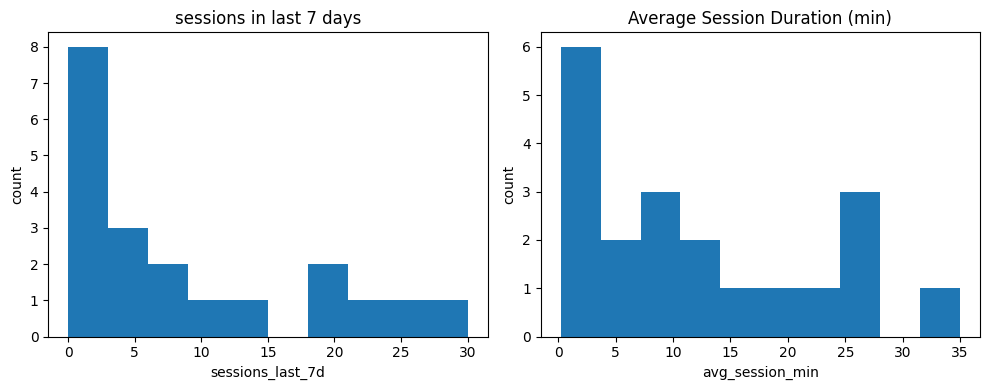

In [22]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# TODO
plt.hist(df['sessions_last_7d'],bins=10)
plt.title('sessions in last 7 days')
plt.xlabel('sessions_last_7d')
plt.ylabel('count')

plt.subplot(1,2,2)
# TODO
plt.hist(df['avg_session_min'].dropna(), bins=10)
plt.title('Average Session Duration (min)')
plt.xlabel('avg_session_min')
plt.ylabel('count')
plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [23]:
# TODO: compute churn rate and counts
churn_rate = df['churned'].mean()
counts = df['churned'].value_counts()
print(churn_rate)
counts

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why? becuase churn is typically imbalanced, accuracy is misleading (a model predicting "no churn" can look good). F1 is better when we care about precision and recall for the positive class, while PR-AUC is preferred when churn is rare and you want a threshold-independent measure focused on positive-class performance. In practice, PR-AUC is the most informative for churn detection under imbalance.


0.3


,count
churned,
False,14
True,6


### Task 3.2: Slice analysis


In [24]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country')['churned'].mean()
by_plan = df.groupby('plan')['churned'].mean()
by_country
by_plan

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2["tenure_bucket"] = pd.cut(df2['tenure_days'], bins=[0, 30, 90, 180, 365, np.inf], labels=['<1m', '1-3m', '3-6m', '6-12m', '1y+'])
by_bucket = df2.groupby('tenure_bucket')['churned'].mean()
by_bucket


/tmp/ipython-input-3657351113.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_country = df.groupby('country')['churned'].mean()
/tmp/ipython-input-3657351113.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_plan = df.groupby('plan')['churned'].mean()
/tmp/ipython-input-3657351113.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bucket = df2.groupby('tenure_bucket')['churned'].mean()


,churned
tenure_bucket,
<1m,0.833333
1-3m,0.000000
3-6m,0.333333
6-12m,0.000000
1y+,0.000000


## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [25]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = 'refund_after_churn_flag', 'last_payment_failed'
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability). refund_after_churn//-flag is explicitly post-outcome information because it can only be known after a user has churned, so using it would leak the label directly into the features. last_payment_failed can also be leakage-prone if the failure occurs at or after the churn decision point, meaning it may not be reliably available at prediction time and could encode near-future information correlated with churn.


('refund_after_churn_flag', 'last_payment_failed')

## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks.
The main data risks are label leakage from post-outcome or near outcome features such as refund_after_churn_flag and potentially last_payment_failed, missing values in fields like age and discount that require principled handling, heavy-tailed and skewed behavioral distributions that can distort averages and model traning, small sample sizes withim country or plan slices that make churn estimates noisy, and unclear temporal cutoffs that increase the risk of using future information unintentionally.

- Top 3 features to create next.
The next features to create would focus on time-aware behavior and normalization, such as recent engagement trends compared to longer windows, lifecycle indicators like tenure buckets or days since signup to capture churn risk over time, and normalized behavioral ratios that combine session frequency and duration to better reflect true user engagement.

- What you would do before training any model.
Before training any model, I would define a strict prediction timestamp, remove or time-shift any leaky features, address missing values and outliers, encode categorical variables appropriately, perform time-aware train-validation splits, select an evaluation metric suitable for class imbalance such as PR-AUC or F1, and establish a simple baseline model to validate the pipeline.
